In [1]:
import transforms as T
import torch
import torchvision
import os
import utils
import torchvision.transforms as trans
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageOps
from skimage import io, data
from skimage.measure import label
from skimage.color import label2rgb, rgb2gray, gray2rgb
from engine import train_one_epoch, evaluate
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
# Make our own dataset
class PVDataSet(torch.utils.data.Dataset):
    def __init__(self, root, d_transforms = None):
        self.root = root
        self.transforms = d_transforms
        
        # Load all image files
        self.imgs = list(os.listdir(os.path.join(root, "img/")))
        self.masks = list(os.listdir(os.path.join(root, "labels/")))
        
    def __getitem__(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root, "img/", self.imgs[idx])
        mask_path = os.path.join(self.root, "labels/", self.masks[idx])
        
        # Convert the image to RGB and resize
        img = Image.open(img_path).convert("RGB")
        
        # Convert to grayscale and resize
        mask = Image.open(mask_path)
        mask = ImageOps.grayscale(mask)
        
        # Convert PIL to np-array
        mask = np.array(mask)
        
        # BLOB Analysis
        label_im = label(mask)
        
        # Instances are different colours
        obj_ids = np.unique(label_im)
        
        # First id is background - remove it
        obj_ids = obj_ids[1:]
        
        # Split into multiple separate mask segments
        masks = (label_im[:, None, None] == obj_ids[:, None, None])
        
        # Convert masks to C, D, H, W
        masks = np.transpose(masks, (2,1,0,3))
        
        # Loop through and get the boxes
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(label_im == obj_ids[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # There is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # Suppose all instances are individual
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [3]:
# Change to use the gpu for training
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [4]:
def get_model_instance_segmentation(num_classes):
    # Load model on pre-trained COCO
    model = models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    
    # Get number of inputs for classifier
    in_feat = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace pre-trained head with new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)
    
    # Get input features for the mask classifier
    in_feat_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # Replace predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_feat_mask, hidden_layer, num_classes)
    
    return model

In [5]:
def get_transform(train):
    # Don't need std and mean as this is handled internally by the model
    d_transforms = []
    d_transforms.append(T.Resize([1125,2000]))
    d_transforms.append(T.PILToTensor())
    d_transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        d_transforms.append(T.RandomHorizontalFlip())
    return T.Compose(d_transforms)

In [6]:
# Build model - using pretrained means it already knows the classification of 1000 classes defined
# in the ImageNet database
# The model is here chosen to be resnet 18, but might be changed for resnet 50 in the future for a faster R-CNN network.
# Note that this current model is NOT an R-CNN, which might mean it's not very good currently since we are looking for
# the region(s) of the picture in which the item is located, not a classification of the image as a whole

# Remake the transforms, now with normalization using the acquired mean and std
train_path = "../Data/train/"
test_path = "../Data/test/"

# Make our datasets
train_ds = PVDataSet(train_path, get_transform(train=True))
test_ds = PVDataSet(test_path, get_transform(train=False))

# Put them into loaders
# Collate_fn ensures correct data padding
# Num_workers speeds up the process by allowing paralell processing
train_loader = torch.utils.data.DataLoader(dataset = train_ds, batch_size = 16, 
                                           shuffle = True, collate_fn=utils.collate_fn) # num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset = test_ds, batch_size = 16, 
                                          shuffle = False, collate_fn=utils.collate_fn) # num_workers=4)

# Define how many new classes we would like to learn - here it is only solar panels for the moment
num_classes = 2 # Solar panels + background

# Prepare matrices for forward propagation using the number of classes and features
model = get_model_instance_segmentation(num_classes)

# Set device to GPU if available
#device = set_device()
device = "cpu"
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

# Define the loss function (between 0.001 - 0.1) & optimizer (Stochastic Gradient Descent)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params, lr = 0.001, momentum = 0.9, weight_decay = 0.003)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [7]:
# Train the nn
num_epochs = 10

for epoch in range(num_epochs):
    # Train one epoch, print every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq = 3)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Evaluate on test set
    evaluate(model, test_loader, device=device)

C:\Users\askeo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [0]  [ 0/15]  eta: 0:34:00  lr: 0.000072  loss: 8.6967 (8.6967)  loss_classifier: 0.4019 (0.4019)  loss_box_reg: 0.0489 (0.0489)  loss_mask: 1.4589 (1.4589)  loss_objectness: 5.8874 (5.8874)  loss_rpn_box_reg: 0.8995 (0.8995)  time: 136.0539  data: 10.8644
Epoch: [0]  [ 3/15]  eta: 0:27:15  lr: 0.000286  loss: 7.3084 (7.8009)  loss_classifier: 0.3824 (0.3829)  loss_box_reg: 0.0477 (0.0477)  loss_mask: 1.3863 (1.2719)  loss_objectness: 4.7154 (5.3062)  loss_rpn_box_reg: 0.6749 (0.7921)  time: 136.3288  data: 10.7599
Epoch: [0]  [ 6/15]  eta: 0:20:32  lr: 0.000501  loss: 6.0339 (5.6449)  loss_classifier: 0.3480 (0.3439)  loss_box_reg: 0.0489 (0.0495)  loss_mask: 0.7676 (0.7817)  loss_objectness: 4.1958 (3.7617)  loss_rpn_box_reg: 0.6749 (0.7081)  time: 136.9850  data: 10.7066
Epoch: [0]  [ 9/15]  eta: 0:13:42  lr: 0.000715  loss: 2.4346 (4.5198)  loss_classifier: 0.2924 (0.2869)  loss_box_reg: 0.0441 (0.0433)  loss_mask: 0.0957 (0.5600)  loss_objectness: 1.4431 (3.0058)  loss_rpn_

KeyboardInterrupt: 

In [8]:
# Save the model and make plots
# pick one image from the test set
img, _ = test_ds[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [11]:
prediction

[{'boxes': tensor([[ 499.3712,  653.0150,  522.6854,  676.0889],
          [ 760.0774,  278.6455,  775.8997,  294.9902],
          [ 734.7385,  582.6592,  759.2032,  598.4745],
          [ 759.1011,  281.9816,  772.3275,  299.9552],
          [1061.0780,  189.0699, 1081.1570,  202.5707],
          [ 730.7240,  582.0168,  750.9695,  596.3834],
          [1014.2822,  747.4902, 1032.5205,  761.0829],
          [ 487.9987,  651.5742,  516.7571,  669.6975],
          [1128.7117,  515.1445, 1145.1356,  526.3830],
          [ 499.7697,  651.0211,  528.4519,  667.8091],
          [1015.9915,  750.8623, 1031.4579,  765.9206],
          [ 742.7876,  584.2575,  763.9551,  600.6998],
          [1020.3167,  749.9156, 1035.3473,  763.0347],
          [ 759.4623,  274.1038,  771.3113,  292.0635],
          [1046.2250,  205.9406, 1056.7412,  215.1592],
          [1012.8101,  750.1177, 1025.4628,  763.6516],
          [ 736.1611,  579.1907,  756.8395,  592.6885],
          [1120.0186,  511.8509, 1132.6

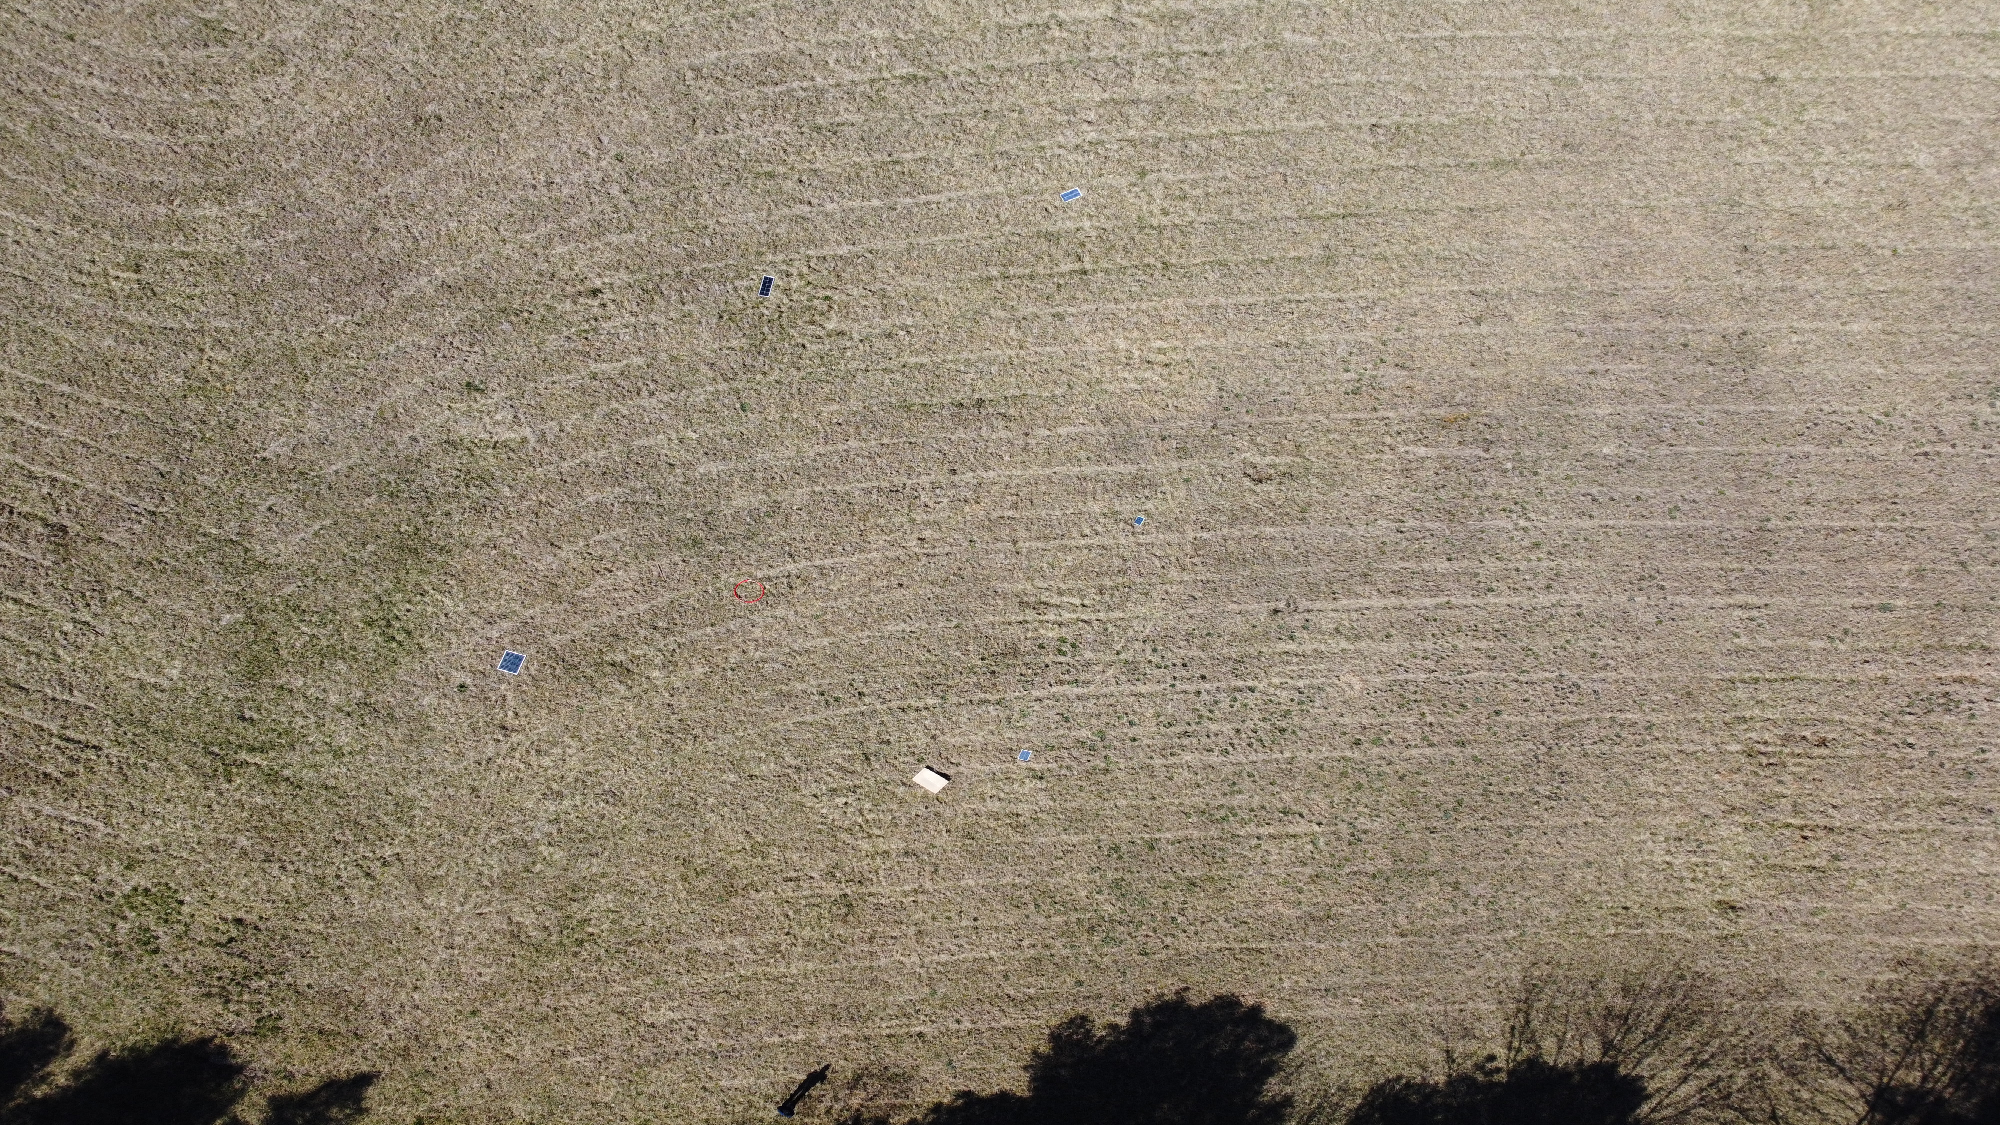

In [9]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

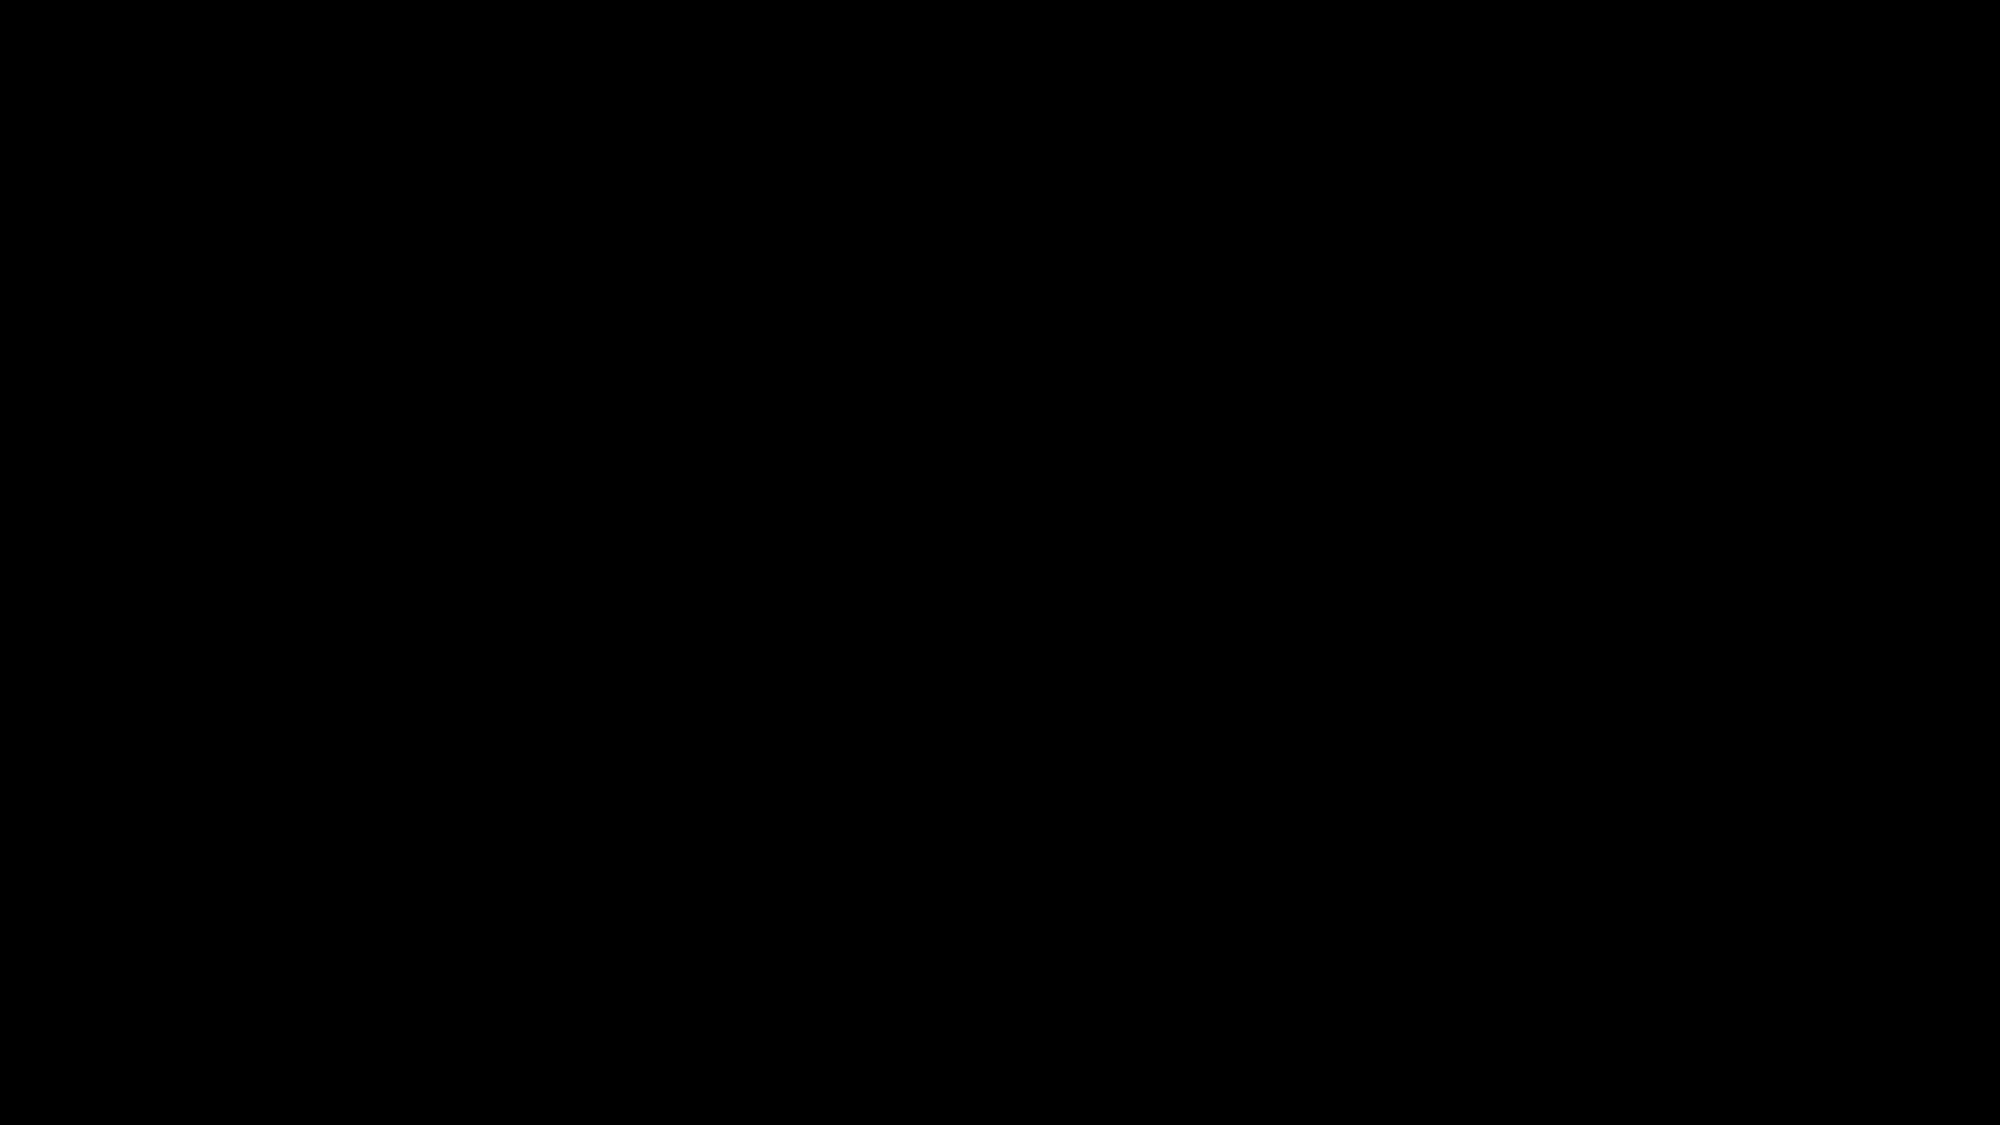

In [10]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
# Testing
img_path = "../Data/train/img/2021_02_03_10_A_90DJI_0032_height_30m.JPG"
mask_path = "../Data/train/labels/2021_02_03_10_A_90DJI_0032_height_30m.png"

# Convert the image to RGB and resize
img = Image.open(img_path).convert("RGB")
w, h = img.size
img = img.resize((w//2, h//2))

# Convert to grayscale and resize
mask = Image.open(mask_path)
mask = ImageOps.grayscale(mask)
w, h = mask.size
mask = mask.resize((w//2, h//2))

# Convert PIL to np-array
mask = np.array(mask)
label_im = label(mask)
vals = np.unique(label_im)
vals = vals[1:]
masks = (label_im[:, None, None] == vals[:, None, None])
masks = np.transpose(masks, (2,1,0,3))

num_objs = len(vals)
boxes = []
for i in range(num_objs):
    pos = np.where(label_im == vals[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])
#print(boxes)


# convert everything into a torch.Tensor
boxes = torch.as_tensor(boxes, dtype=torch.float32)

# there is only one class
labels = torch.ones((num_objs,), dtype=torch.int64)
masks = torch.as_tensor(masks, dtype=torch.uint8)

image_id = torch.tensor(0)
area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
# suppose all instances are individual
iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
print(np.shape(masks))

masks[0,:,:,:].permute(0,2,1)
print(np.shape(masks[0,:,:,:]))